# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import six
from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

# tf.__version__sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# print("VERSION", tf.__version__sess)

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3355218038566810346, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 10368211354
 locality {
   bus_id: 1
 }
 incarnation: 5839149660130780740
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0"]

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
# sys.path.append("..")
sys.path.append("./object_detection/") # Pavlo's machine
# sys.path.append("../../../../../../tensorflow-models/models/research/object_detection/") # Pavlo's machine

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

from utils import dataset_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# Change this to the dir
DATA_DIR = './data_capstone'

# What model to download.

# MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_NAME = 'faster_rcnn_resnet101_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_CKPT = os.path.join(DATA_DIR, MODEL_NAME + '/frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('./object_detection', 'data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [5]:
# opener = urllib.request.URLopener()
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
# tar_file = tarfile.open(MODEL_FILE)
# for file in tar_file.getmembers():
#   file_name = os.path.basename(file.name)
#   if 'frozen_inference_graph.pb' in file_name:
#     tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [8]:
print(category_index)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

## Helper code

In [9]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [30]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.

# PATH_TO_TEST_IMAGES_DIR = os.path.join(DATA_DIR, 'test_images')
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'just_traffic_light_0{}.jpg'.format(120 + i)) for i in range(0, 3) ]

PATH_TO_TEST_IMAGES_DIR = os.path.join(DATA_DIR, 'sim_test_images_filtered')
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'session1_{:02d}.jpg'.format(i + 1)) for i in range(0, 5) ]

print(TEST_IMAGE_PATHS)


# Size, in inches, of the output images.
IMAGE_SIZE = (16, 12)

['./data_capstone/sim_test_images_filtered/session1_01.jpg', './data_capstone/sim_test_images_filtered/session1_02.jpg', './data_capstone/sim_test_images_filtered/session1_03.jpg', './data_capstone/sim_test_images_filtered/session1_04.jpg', './data_capstone/sim_test_images_filtered/session1_05.jpg']


In [11]:
def encode_image_array_as_jpg_str(image):
  """Encodes a numpy array into a JPEG string.

  Args:
    image: a numpy array with shape [height, width, 3].

  Returns:
    JPEG encoded image string.
  """
  image_pil = Image.fromarray(np.uint8(image))
  output = six.BytesIO()
  image_pil.save(output, format='JPEG')
  jpg_string = output.getvalue()
  output.close()
  return jpg_string

def create_record(boxes, newclass, image, filepath):
    textlabel = [ 'RED', 'YELLOW', 'GREEN' ]
    label = [ 1, 2, 3 ]
    
    height = image.shape[0]
    width = image.shape[1]
    filename = filepath
    encoded_image_data = encode_image_array_as_jpg_str(image)
    image_format = b'jpeg'

    ymins = []
    xmins = []
    ymaxs = []
    xmaxs = []
    classes_text = []
    classes = []
    
    for box in boxes:
        ymins.append(box[0])
        xmins.append(box[1])
        ymaxs.append(box[2])
        xmaxs.append(box[3])
        classes_text.append(textlabel[newclass].encode('utf-8'))
        classes.append(label[newclass])
        
#     print('classes = ', classes)

    
#     xmins = [ box[1] ] # List of normalized left x coordinates in bounding box (1 per box)
#     xmaxs = [ box[3] ] # List of normalized right x coordinates in bounding box
#     # (1 per box)
#     ymins = [ box[0] ] # List of normalized top y coordinates in bounding box (1 per box)
#     ymaxs = [ box[2] ] # List of normalized bottom y coordinates in bounding box
#     # (1 per box)
#     classes_text = [ textlabel[newclass].encode('utf-8') ] # List of string class name of bounding box (1 per box)
#     classes = [ label[newclass] ] # List of integer class id of bounding box (1 per box)

    tf_record = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename.encode('utf-8')),
        'image/source_id': dataset_util.bytes_feature(filename.encode('utf-8')),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_record

IMAGE_FILES_CSV =  ./data_capstone/sim_test_images_filtered/session1.csv
IMAGE_FILES_CSV =  ./data_capstone/sim_test_images_filtered/session2.csv
imagefiles1 len =  520
labels1 len =  520
imagefiles2 len =  416
labels2 len =  416
imagefiles len =  936
labels len =  936
imagefiles_train len =  795
labels_train len =  795
imagefiles_test len =  141
labels_test len =  141
Preparing tf records:  ./data_capstone/train_data/train_data_multi2.record  ...
processing image  ./data_capstone/sim_test_images_filtered/session1_347.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_86.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_170.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_79.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_2.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1

classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_342.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_235.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_267.jpg
classes =  [1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_306.jpg
classes =  [3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session2_147.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_216.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_223.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_192.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_150.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_326.jpg
classes =  [1, 1, 1]
processing imag

classes =  [1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_156.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_147.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_176.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_28.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session2_3.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_205.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_351.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_74.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_181.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_164.jpg
classes =  [1, 1, 1, 1]
processing im

classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_10.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_1.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_409.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_116.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_126.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_85.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_104.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_5.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_101.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_355.jpg
classes =  [1, 1, 1]
processing imag

classes =  [1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_299.jpg
classes =  [3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_165.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_87.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_480.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_395.jpg
classes =  [1, 1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_124.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_296.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_80.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_476.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_65.jpg
classes =  [3, 3, 3]
processing imag

classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_268.jpg
classes =  [1, 1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_93.jpg
classes =  [1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_407.jpg
classes =  [1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_202.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_127.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_266.jpg
classes =  [1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_192.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_320.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_194.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_145.jpg
classes =  [3, 3, 3]
processing image

classes =  [3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session2_152.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_281.jpg
classes =  [1, 1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_90.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_316.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_444.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_162.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_222.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session2_120.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_326.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_30.jpg
classes =  [1, 1, 1]
processing 

classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_403.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_236.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_396.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_246.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_502.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_366.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_535.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_119.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_429.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_372.jpg
classes =  [1, 1, 1]
processin

classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_298.jpg
classes =  [3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_14.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_168.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_40.jpg
classes =  [1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_522.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_398.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_199.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session2_249.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_228.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_277.jpg
classes =  [1, 1]
processing image  ./

classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_332.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_489.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_172.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_295.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_203.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_404.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_291.jpg
classes =  [1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_443.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_521.jpg
processing image  ./data_capstone/sim_test_images_filtered/session1_362.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone

classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_148.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_123.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_23.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_309.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_6.jpg
classes =  [3, 3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session1_251.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_367.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_146.jpg
classes =  [3, 3]
processing image  ./data_capstone/sim_test_images_filtered/session2_404.jpg
classes =  [1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_162.jpg
classes =  [3, 3, 3]
processing image  

classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_512.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_130.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session1_90.jpg
classes =  [1, 1, 1]
processing image  ./data_capstone/sim_test_images_filtered/session2_393.jpg
classes =  [1, 1, 1]
recorded 141 records
annotated images len =  935


'\nwriter = tf.python_io.TFRecordWriter(RECORD_FILE_NAME)\nwith detection_graph.as_default():\n  with tf.Session(graph=detection_graph) as sess:\n    # Definite input and output Tensors for detection_graph\n    image_tensor = detection_graph.get_tensor_by_name(\'image_tensor:0\')\n    # Each box represents a part of the image where a particular object was detected.\n    detection_boxes = detection_graph.get_tensor_by_name(\'detection_boxes:0\')\n    # Each score represent how level of confidence for each of the objects.\n    # Score is shown on the result image, together with the class label.\n    detection_scores = detection_graph.get_tensor_by_name(\'detection_scores:0\')\n    detection_classes = detection_graph.get_tensor_by_name(\'detection_classes:0\')\n    num_detections = detection_graph.get_tensor_by_name(\'num_detections:0\')\n    for image_path, image_label in zip(imagefiles, labels): # TEST_IMAGE_PATHS\n      image = Image.open(image_path)\n      # the array based representa

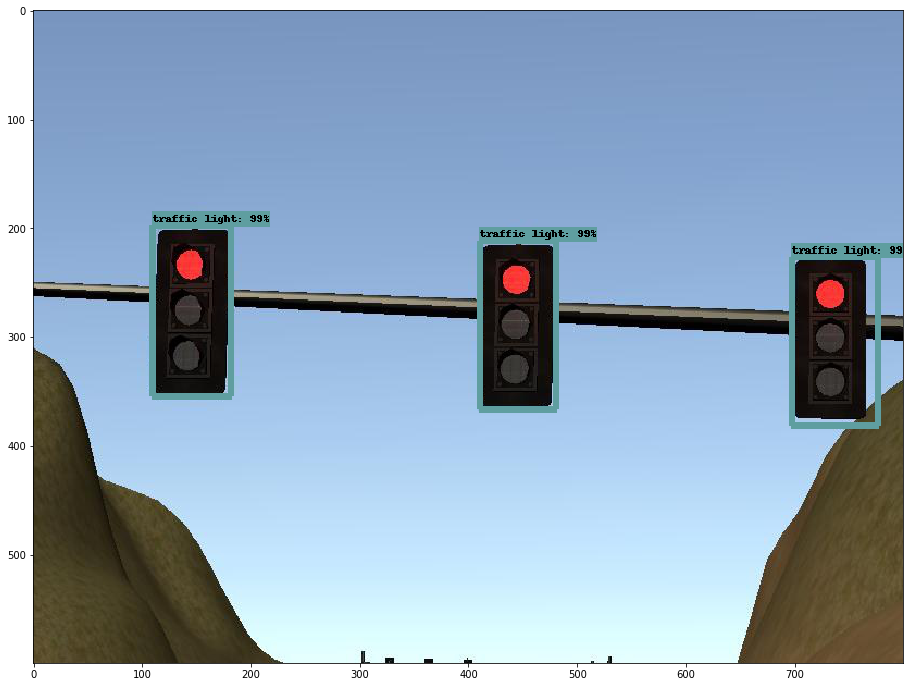

In [42]:
TRAFFIC_LIGHT = 10
THRESHOLD = 0.80

IMAGE_FILES_DIR = os.path.join(DATA_DIR, 'sim_test_images_filtered')
IMAGE_FILES_CSV1 = os.path.join(IMAGE_FILES_DIR, 'session1.csv')
IMAGE_FILES_CSV2 = os.path.join(IMAGE_FILES_DIR, 'session2.csv')

RECORD_FILE_NAME_TRAIN = os.path.join(DATA_DIR, 'train_data', 'train_data_multi2.record')
RECORD_FILE_NAME_TEST = os.path.join(DATA_DIR, 'train_data', 'test_data_multi2.record')


def load_images_labels(csv_file, images_dir):
    imagefiles = []
    labels = []

    print('IMAGE_FILES_CSV = ', csv_file)

    with open(csv_file) as f:
      cnt = 0
      for line in f:
        if cnt > 0:
          data = line.split(',')
          data_path = data[7].replace("'", "")
          image_path = data_path.split('/')[3]
          imagefiles.append(os.path.join(images_dir, image_path))
          labels.append(int(data[8]))
        cnt += 1
    return imagefiles, labels


imagefiles = []
labels = []

imagefiles1, labels1 = load_images_labels(IMAGE_FILES_CSV1, IMAGE_FILES_DIR)
imagefiles2, labels2 = load_images_labels(IMAGE_FILES_CSV2, IMAGE_FILES_DIR)

print('imagefiles1 len = ', len(imagefiles1))
print('labels1 len = ', len(labels1))

print('imagefiles2 len = ', len(imagefiles2))
print('labels2 len = ', len(labels2))



imagefiles.extend(imagefiles1)
imagefiles.extend(imagefiles2)
labels.extend(labels1)
labels.extend(labels2)

print('imagefiles len = ', len(imagefiles))
print('labels len = ', len(labels))

imagefiles_train, imagefiles_test, labels_train, labels_test = train_test_split(
    imagefiles, labels, test_size=0.15, random_state=42)

print('imagefiles_train len = ', len(imagefiles_train))
print('labels_train len = ', len(labels_train))

print('imagefiles_test len = ', len(imagefiles_test))
print('labels_test len = ', len(labels_test))


annotated_images = []


def prepare_tf_record_file(images, labels, record_filename):
    print('Preparing tf records: ', record_filename, ' ...')
    writer = tf.python_io.TFRecordWriter(record_filename)
    records_cnt = 0
    with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path, image_label in zip(images, labels): # TEST_IMAGE_PATHS
          print('processing image ', image_path)
          image = Image.open(image_path)
          # the array based representation of the image will be used later in order to prepare the
          # result image with boxes and labels on it.
          image_np = load_image_into_numpy_array(image)
          # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
          image_np_expanded = np.expand_dims(image_np, axis=0)
          # Actual detection.
          (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

          classes = np.squeeze(classes).astype(np.int32)
          boxes = np.squeeze(boxes)
          scores = np.squeeze(scores)

          light_classes = []
          light_boxes = []
          light_scores = []
          for j in range(len(classes)):
            if classes[j] == TRAFFIC_LIGHT:
                if scores[j] is not None and scores[j] > THRESHOLD:
#                     print("score:", scores[j],"box:",boxes[j])
                    light_classes.append(classes[j])
                    light_boxes.append(boxes[j])
                    light_scores.append(scores[j])
          if len(light_boxes) > 0:
#               print('len boxes = ', len(light_boxes))
              record = create_record(light_boxes, image_label, image_np, image_path)
              writer.write(record.SerializeToString())
              records_cnt += 1
              
#               print('light_boxes = ', light_boxes)
#               print('light_classes = ', light_classes)
#               print('light_scores = ', light_scores)
                
                
              vis_util.visualize_boxes_and_labels_on_image_array(
                  image_np,
                  np.array(light_boxes),
                  np.array(light_classes),
                  np.array(light_scores),
                  category_index,
                  use_normalized_coordinates=True,
                  line_thickness=6)
              annotated_images.append(image_np)
#               plt.figure(figsize=IMAGE_SIZE)
#               plt.imshow(image_np)

    writer.close()
    print('recorded {} records'.format(records_cnt))
  

# prepare_tf_record_file(imagefiles1, labels1, RECORD_FILE_NAME_TRAIN+'-test')
# prepare_tf_record_file(imagefiles2, labels2, RECORD_FILE_NAME_TRAIN+'-test')




    
prepare_tf_record_file(imagefiles_train, labels_train, RECORD_FILE_NAME_TRAIN)
prepare_tf_record_file(imagefiles_test, labels_test, RECORD_FILE_NAME_TEST)


print('annotated images len = ', len(annotated_images))

plt.figure(figsize=IMAGE_SIZE)
plt.imshow(annotated_images[0])
        
# print('imagefiles = ', imagefiles[:10])
# print('labels = ', labels[:10])

'''
writer = tf.python_io.TFRecordWriter(RECORD_FILE_NAME)
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path, image_label in zip(imagefiles, labels): # TEST_IMAGE_PATHS
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      
      classes = np.squeeze(classes).astype(np.int32)
      boxes = np.squeeze(boxes)
      scores = np.squeeze(scores)
    
      light_classes = []
      light_boxes = []
      light_scores = []
      for j in range(len(classes)):
        if classes[j] == TRAFFIC_LIGHT:
            if scores[j] is not None and scores[j] > THRESHOLD:
                print("score:", scores[j],"box:",boxes[j])
                light_classes.append(classes[j])
                light_boxes.append(boxes[j])
                light_scores.append(scores[j])
                record = create_record(boxes[j], image_label, image_np, image_path)
                writer.write(record.SerializeToString())
#                 print('record = ', record)
    
#       print('boxes = ', boxes)
#       print('classes = ', classes)
#       print('scores = ', scores)
      # Visualization of the results of a detection.
     
#       vis_util.visualize_boxes_and_labels_on_image_array(
#           image_np,
#           np.squeeze(light_boxes),
#           np.squeeze(light_classes).astype(np.int32),
#           np.squeeze(light_scores),
#           category_index,
#           use_normalized_coordinates=True,
#           line_thickness=6)
#       plt.figure(figsize=IMAGE_SIZE)
#       plt.imshow(image_np)
     
        
writer.close()
'''


In [15]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()

import moviepy.editor as mpy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [43]:
foutput = os.path.join(DATA_DIR, 'train_data', 'video.mp4')


# TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[:60]

fps = 30
vduration = len(annotated_images)/fps

img_index = 0
def make_frame(t):
    global img_index
#     print('t = ', t, img_index)
    
    image = annotated_images[img_index]
    
    if img_index < len(annotated_images)-1:
        img_index += 1
    return image

clip = mpy.VideoClip(make_frame, duration=vduration) # 2 seconds
clip.write_videofile(foutput, audio=False, fps=30)

[MoviePy] >>>> Building video ./data_capstone/train_data/video.mp4
[MoviePy] Writing video ./data_capstone/train_data/video.mp4


100%|█████████▉| 935/936 [00:06<00:00, 150.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./data_capstone/train_data/video.mp4 

